In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.src.utils import load_img
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import  layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, concatenate, Flatten, Dense,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform, Constant
from keras.utils import to_categorical
from keras.models import Model
import numpy as np
import cv2
from keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read Data

In [ ]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
validation_path ='/kaggle/input/intel-image-classification/seg_test/seg_test'

In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

# Specify the target size for resizing
target_size = (224, 224)

# Initialize the lists to store images and labels for both train and test data
X_train = []  # List for train images
y_train = []  # List for train labels
X_test = []   # List for test images
y_test = []   # List for test labels

# Function to read and process data
def process_data(data_path, X, y):
    for label, emotion in enumerate(os.listdir(data_path)):
        emotion_path = os.path.join(data_path, emotion)
        if os.path.isdir(emotion_path):
            for filename in os.listdir(emotion_path):
                image_path = os.path.join(emotion_path, filename)
                if os.path.isfile(image_path):
                    # Read the image in color
                    img = cv2.imread(image_path)

                    # Resize the image to the target size
                    img = cv2.resize(img, target_size)

                    # Append the resized image to X
                    X.append(img)

                    # Append the label to y
                    y.append(label)

# Process train data
process_data(train_path, X_train, y_train)

# Shuffle the training data (X_train and y_train)
X_train, y_train = shuffle(X_train, y_train)

# Convert X_train and y_train to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Process test data
process_data(validation_path, X_test, y_test)

# Shuffle the validation data (X_test and y_test)
X_test, y_test = shuffle(X_test, y_test)

# Convert X_test and y_test to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
len(np.unique(y_train))

6

In [ ]:
X_train.shape

(14034, 224, 224, 3)

In [ ]:
X_test.shape

(3000, 224, 224, 3)

In [ ]:
# Define initializers
kernel_init = glorot_uniform()
bias_init = Constant(value=0.2)

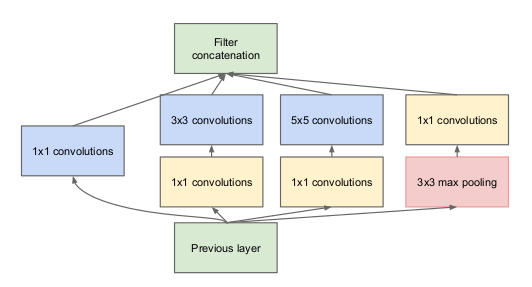

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [ ]:
input_layer = Input(shape=(224, 224,3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation="softmax", name='output')(x)

/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


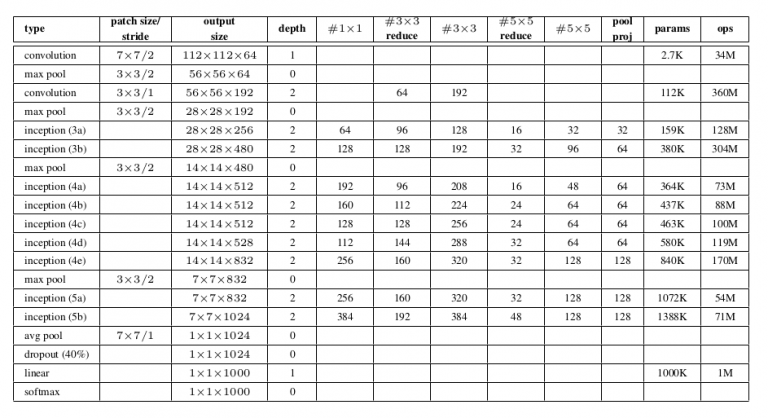

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
#Compile and train the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
878/878 [==============================] - 82s 64ms/step - loss: 3.8431 - output_loss: 1.2944 - auxilliary_output_1_loss: 1.2638 - auxilliary_output_2_loss: 1.2849 - output_accuracy: 0.4538 - auxilliary_output_1_accuracy: 0.5027 - auxilliary_output_2_accuracy: 0.4715 - val_loss: 3.5690 - val_output_loss: 1.1857 - val_auxilliary_output_1_loss: 1.2485 - val_auxilliary_output_2_loss: 1.1347 - val_output_accuracy: 0.5067 - val_auxilliary_output_1_accuracy: 0.4973 - val_auxilliary_output_2_accuracy: 0.5313
Epoch 2/10
878/878 [==============================] - 52s 59ms/step - loss: 2.9073 - output_loss: 0.9617 - auxilliary_output_1_loss: 0.9691 - auxilliary_output_2_loss: 0.9766 - output_accuracy: 0.6098 - auxilliary_output_1_accuracy: 0.6068 - auxilliary_output_2_accuracy: 0.6007 - val_loss: 2.6346 - val_output_loss: 0.8875 - val_auxilliary_output_1_loss: 0.8443 - val_auxilliary_output_2_loss: 0.9027 - val_output_accuracy: 0.6227 - val_auxilliary_output_1_accuracy: 0.6627 - val_a

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

94/94 [==============================] - 6s 48ms/step - loss: 1.7619 - output_loss: 0.6032 - auxilliary_output_1_loss: 0.5970 - auxilliary_output_2_loss: 0.5617 - output_accuracy: 0.7717 - auxilliary_output_1_accuracy: 0.7780 - auxilliary_output_2_accuracy: 0.7877


[1.761873722076416,
 0.6031913161277771,
 0.5969529747962952,
 0.5617291927337646,
 0.7716666460037231,
 0.777999997138977,
 0.7876666784286499]

In [ ]:
# Make predictions
predictions = model.predict(X_test)

94/94 [==============================] - 3s 31ms/step


In [ ]:
y_test.shape

(3000,)

In [ ]:
# Make predictions
predictions, aux_output_1, aux_output_2 = model.predict(X_test)

# Convert predictions to NumPy arrays
predictions_array = np.array(predictions)
aux_output_1_array = np.array(aux_output_1)
aux_output_2_array = np.array(aux_output_2)

# Get the shape of the arrays
predictions_shape = predictions_array.shape
aux_output_1_shape = aux_output_1_array.shape
aux_output_2_shape = aux_output_2_array.shape

print("Shape of predictions array:", predictions_shape)
print("Shape of aux_output_1 array:", aux_output_1_shape)
print("Shape of aux_output_2 array:", aux_output_2_shape)


94/94 [==============================] - 3s 31ms/step
Shape of predictions array: (3000, 6)
Shape of aux_output_1 array: (3000, 10)
Shape of aux_output_2 array: (3000, 10)


In [ ]:
y_predicted = np.argmax(predictions_array, axis=1)

In [ ]:
np.array(y_predicted).shape

(3000,)

In [ ]:
y_predicted[:5]

array([4, 0, 4, 4, 0])

In [ ]:
y_test[:5]

array([4, 0, 1, 4, 3])

In [ ]:
con_matrix=confusion_matrix(y_test,y_predicted)

Text(0.5, 23.52222222222222, 'Predicted')

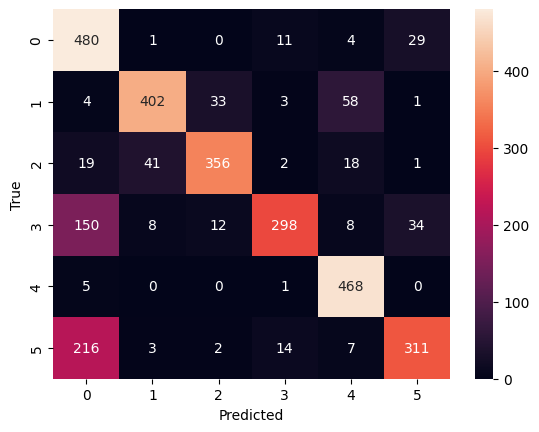

In [ ]:
sns.heatmap(con_matrix,annot=True,fmt="d")
plt.ylabel('True')
plt.xlabel('Predicted')

In [ ]:
CR=classification_report(y_test,y_predicted)
print(CR)

              precision    recall  f1-score   support

           0       0.55      0.91      0.69       525
           1       0.88      0.80      0.84       501
           2       0.88      0.81      0.85       437
           3       0.91      0.58      0.71       510
           4       0.83      0.99      0.90       474
           5       0.83      0.56      0.67       553

    accuracy                           0.77      3000
   macro avg       0.81      0.78      0.78      3000
weighted avg       0.81      0.77      0.77      3000



# **Part 2 using built in function**

In [ ]:
model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Add layers using calls:
x = model.output  # Get the output of the InceptionV3 base
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
predictions = tf.keras.layers.Dense(6, activation="softmax")(x)

# Create a new Functional model with these layers:
model2 = tf.keras.Model(inputs=model.input, outputs=predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#Compile and train the model
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# # Assuming y_train and y_test are your integer labels
# y_train_categorical = to_categorical(y_train, num_classes=6)
# y_test_categorical = to_categorical(y_test, num_classes=6)

In [ ]:
history=model2.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
878/878 [==============================] - 50s 49ms/step - loss: 3.4264 - accuracy: 0.4992 - val_loss: 1.2014 - val_accuracy: 0.5303
Epoch 2/10
878/878 [==============================] - 39s 44ms/step - loss: 1.1197 - accuracy: 0.5718 - val_loss: 1.0545 - val_accuracy: 0.5943
Epoch 3/10
878/878 [==============================] - 39s 44ms/step - loss: 1.0536 - accuracy: 0.5993 - val_loss: 1.0469 - val_accuracy: 0.6017
Epoch 4/10
878/878 [==============================] - 39s 44ms/step - loss: 1.0258 - accuracy: 0.6092 - val_loss: 1.1155 - val_accuracy: 0.5823
Epoch 5/10
878/878 [==============================] - 39s 44ms/step - loss: 0.9900 - accuracy: 0.6320 - val_loss: 1.0461 - val_accuracy: 0.6037
Epoch 6/10
878/878 [==============================] - 39s 44ms/step - loss: 0.9886 - accuracy: 0.6273 - val_loss: 0.9911 - val_accuracy: 0.6297
Epoch 7/10
878/878 [==============================] - 39s 44ms/step - loss: 0.9709 - accuracy: 0.6325 - val_loss: 1.0515 - val_accuracy:

In [ ]:
model2.evaluate(X_test,y_test)

94/94 [==============================] - 9s 79ms/step - loss: 1.0738 - accuracy: 0.6070


[1.0738378763198853, 0.6069999933242798]

In [ ]:
# Make predictions
predictions = model2.predict(X_test)

94/94 [==============================] - 7s 61ms/step


In [ ]:
predictions.shape

(3000, 6)

In [ ]:
y_predicted = np.argmax(predictions_array, axis=1)

In [ ]:
y_predicted.shape

(3000,)

In [ ]:
con_matrix=confusion_matrix(y_test,y_predicted)

Text(0.5, 23.52222222222222, 'Predicted')

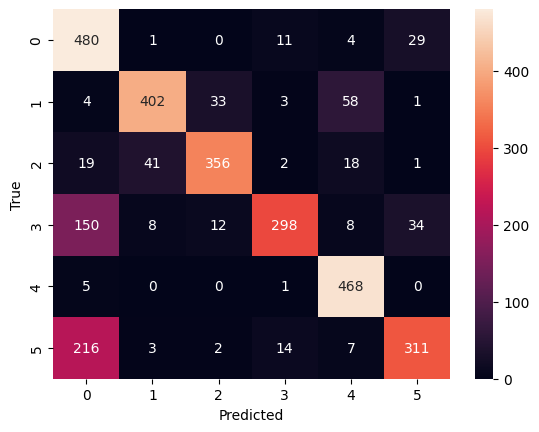

In [ ]:
sns.heatmap(con_matrix,annot=True,fmt="d")
plt.ylabel('True')
plt.xlabel('Predicted')

In [ ]:
CR=classification_report(y_test,y_predicted)
print(CR)

              precision    recall  f1-score   support

           0       0.55      0.91      0.69       525
           1       0.88      0.80      0.84       501
           2       0.88      0.81      0.85       437
           3       0.91      0.58      0.71       510
           4       0.83      0.99      0.90       474
           5       0.83      0.56      0.67       553

    accuracy                           0.77      3000
   macro avg       0.81      0.78      0.78      3000
weighted avg       0.81      0.77      0.77      3000

